<a href="https://colab.research.google.com/github/achelousace/Prediction-of-Product/blob/main/Prediction_of_Product_Sales_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prediction of Product Sales**
## by: Mohammad Abu Ayyash

#Step 1: **Importing Necessary Libraries**
####This is the step where we import all the libraries we need for our work.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import BaggingRegressor
from sklearn import set_config
set_config(transform_output='pandas')
pd.set_option('display.max_columns',100)

## Custom Functions

In [3]:
def explore_numeric(df, x, figsize=(6,5) ):
  gridspec = {'height_ratios':[0.7,0.3]}
  fig, axes = plt.subplots(nrows=2, figsize=figsize,sharex=True, gridspec_kw=gridspec)
  sns.histplot(data=df, x=x, ax=axes[0])
  sns.boxplot(data=df, x=x, ax=axes[1])
  axes[0].set_title(f"Column: {x}")
  fig.tight_layout()
  plt.show()
  null_count = df[x].isna().sum()
  null_perc = null_count/len(df)* 100
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")

In [4]:
def plot_numeric_vs_target(df, x, y='Item_Outlet_Sales', figsize=(6,4), **kwargs):
  corr = df[[x,y]].corr().round(2)
  r = corr.loc[x,y]
  fig, ax = plt.subplots(figsize=figsize)
  scatter_kws={'ec':'white','linewidths':1,'alpha':0.8}
  sns.regplot(data=df, x=x, y=y, ax=ax, scatter_kws=scatter_kws, **kwargs)
  ax.set_title(f"{x} vs. {y} (r = {r})")
  plt.show()
  return fig, ax

In [5]:
def explore_categorical(df, x, fillna = True, placeholder = 'MISSING', figsize = (6,4), order = None):
  temp_df = df.copy()
  null_count = temp_df[x].isna().sum()
  null_perc = null_count/len(temp_df)* 100
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  fig, ax = plt.subplots(figsize=figsize)
  sns.countplot(data=temp_df, x=x, ax=ax, order=order)
  ax.set_xticks(ax.get_xticks())
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  ax.set_title(f"Column: {x}")
  fig.tight_layout()
  plt.show()
  print(f"- NaN's Found: {null_count} ({round(null_perc,2)}%)")
  nunique = temp_df[x].nunique()
  print(f"- Unique Values: {nunique}")
  val_counts = temp_df[x].value_counts(dropna=False)
  most_common_val = val_counts.index[0]
  freq = val_counts.values[0]
  perc_most_common = freq / len(temp_df) * 100
  print(f"- Most common value: '{most_common_val}' occurs {freq} times ({round(perc_most_common,2)}%)")
  if perc_most_common > 98:
    print(f"\n- [!] Warning: '{x}' is a constant or quasi-constant feature and should be dropped.")
  else:
    print("- Not constant or quasi-constant.")
  return fig, ax

In [6]:
def plot_categorical_vs_target(df, x, y='Item_Outlet_Sales',figsize=(6,4),fillna = True, placeholder = 'MISSING',order = None):
  temp_df = df.copy()
  if fillna == True:
    temp_df[x] = temp_df[x].fillna(placeholder)
  else:
    temp_df = temp_df.dropna(subset=[x])
  fig, ax = plt.subplots(figsize=figsize)
  sns.barplot(data=temp_df, x=x, y=y, ax=ax, order=order, alpha=0.6,linewidth=1, edgecolor='black', errorbar=None)
  sns.stripplot(data=temp_df, x=x, y=y, hue=x, ax=ax, order=order, hue_order=order, legend=False,edgecolor='white', linewidth=0.5,size=3,zorder=0)
  ax.set_xticks(ax.get_xticks())
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')
  ax.set_title(f"{x} vs. {y}")
  fig.tight_layout()
  return fig, ax

In [7]:
def regression_metrics(y_true, y_pred, label='', verbose = True, output_dict=False):
  mae = mean_absolute_error(y_true, y_pred)
  mse = mean_squared_error(y_true, y_pred)
  rmse = mean_squared_error(y_true, y_pred, squared=False)
  r_squared = r2_score(y_true, y_pred)
  if verbose == True:
    header = "-"*60
    print(header, f"Regression Metrics: {label}", header, sep='\n')
    print(f"- MAE = {mae:,.3f}")
    print(f"- MSE = {mse:,.3f}")
    print(f"- RMSE = {rmse:,.3f}")
    print(f"- R^2 = {r_squared:,.3f}")
  if output_dict == True:
      metrics = {'Label':label, 'MAE':mae,'MSE':mse, 'RMSE':rmse, 'R^2':r_squared}
      return metrics
def evaluate_regression(reg, X_train, y_train, X_test, y_test, verbose = True,output_frame=False):
  y_train_pred = reg.predict(X_train)
  results_train = regression_metrics(y_train, y_train_pred, verbose = verbose,output_dict=output_frame,label='Training Data')
  print()
  y_test_pred = reg.predict(X_test)
  results_test = regression_metrics(y_test, y_test_pred, verbose = verbose,output_dict=output_frame,label='Test Data' )
  if output_frame:
    results_df = pd.DataFrame([results_train,results_test])
    results_df = results_df.set_index('Label')
    results_df.index.name=None
    return results_df.round(3)

In [8]:
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),textcoords='offset points'):
    for bar in ax.patches:
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,xytext=xytext, textcoords=textcoords)

In [9]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5),
                intercept=False, intercept_name="intercept",
                annotate=False, ha='left', va='center', size=12,
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient',
            ylabel='Feature Names',
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax

In [10]:
def get_importances(model, feature_names=None,name='Feature Importance',sort=False, ascending=True):
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,name=name)
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
    return importances

In [11]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',ylabel='Feature Names',title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

In [12]:
def get_color_dict(importances, color_rest='#006ba4' , color_top='green',top_n=7):
    ## color -coding top 5 bars
    highlight_feats = importances.sort_values(ascending=True).tail(top_n).index
    colors_dict = {col: color_top if col in highlight_feats else color_rest for col in importances.index}
    return colors_dict

In [13]:
def plot_importance_color(importances, top_n=None,  figsize=(8,6), color_dict=None):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## create plot with colors, if provided
    if color_dict is not None:
        ## Getting color list and saving to plot_kws
        colors = plot_vals.index.map(color_dict)
        ax = plot_vals.plot(kind='barh', figsize=figsize, color=colors)
    else:
        ## create plot without colors, if not provided
        ax = plot_vals.plot(kind='barh', figsize=figsize)

    # set titles and axis labels
    ax.set(xlabel='Importance',
           ylabel='Feature Names',
           title=title)
    ## return ax in case want to continue to update/modify figure
    return ax

#Step 2: **Loading The Dataset**
####This is the step where we load our dataset using pandas

In [14]:
df = pd.read_csv("/content/drive/MyDrive/StudentFolders16wk24wk/CodingDojo/01-Fundamentals/Week02/Data/sales_predictions_2023.csv")

In [15]:
df.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [17]:
df.describe(include='all')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523,7060.000000,8523,8523.000000,8523,8523.000000,8523,8523.000000,6113,8523,8523,8523.000000
unique,1559,NaN,5,NaN,16,NaN,10,NaN,3,3,4,NaN
top,FDW13,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,OUT027,NaN,Medium,Tier 3,Supermarket Type1,NaN
freq,10,NaN,5089,NaN,1232,NaN,935,NaN,2793,3350,5577,NaN
mean,NaN,12.857645,NaN,0.066132,NaN,140.992782,NaN,1997.831867,NaN,NaN,NaN,2181.288914
std,NaN,4.643456,NaN,0.051598,NaN,62.275067,NaN,8.371760,NaN,NaN,NaN,1706.499616
min,NaN,4.555000,NaN,0.000000,NaN,31.290000,NaN,1985.000000,NaN,NaN,NaN,33.290000
25%,NaN,8.773750,NaN,0.026989,NaN,93.826500,NaN,1987.000000,NaN,NaN,NaN,834.247400
50%,NaN,12.600000,NaN,0.053931,NaN,143.012800,NaN,1999.000000,NaN,NaN,NaN,1794.331000
75%,NaN,16.850000,NaN,0.094585,NaN,185.643700,NaN,2004.000000,NaN,NaN,NaN,3101.296400


#Step 3: **Data Cleaning**
####This is the step where we analyze the data to know if there are problems in it and solving these problems accordingly.

### **Summary**

In [18]:
df.shape

(8523, 12)

In [19]:
df.dtypes

,0
Item_Identifier,object
Item_Weight,float64
Item_Fat_Content,object
Item_Visibility,float64
Item_Type,object
Item_MRP,float64
Outlet_Identifier,object
Outlet_Establishment_Year,int64
Outlet_Size,object
Outlet_Location_Type,object


* 12 columns , 8523 rows
* data type : object = 7 , numeric  = 5

###**Handling Duplicates**

In [20]:
dup = df.duplicated(keep=False)
dup.sum()

0

* No dublicates

###  **Handling Missing Values**

In [21]:
df.isna().sum()

,0
Item_Identifier,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0


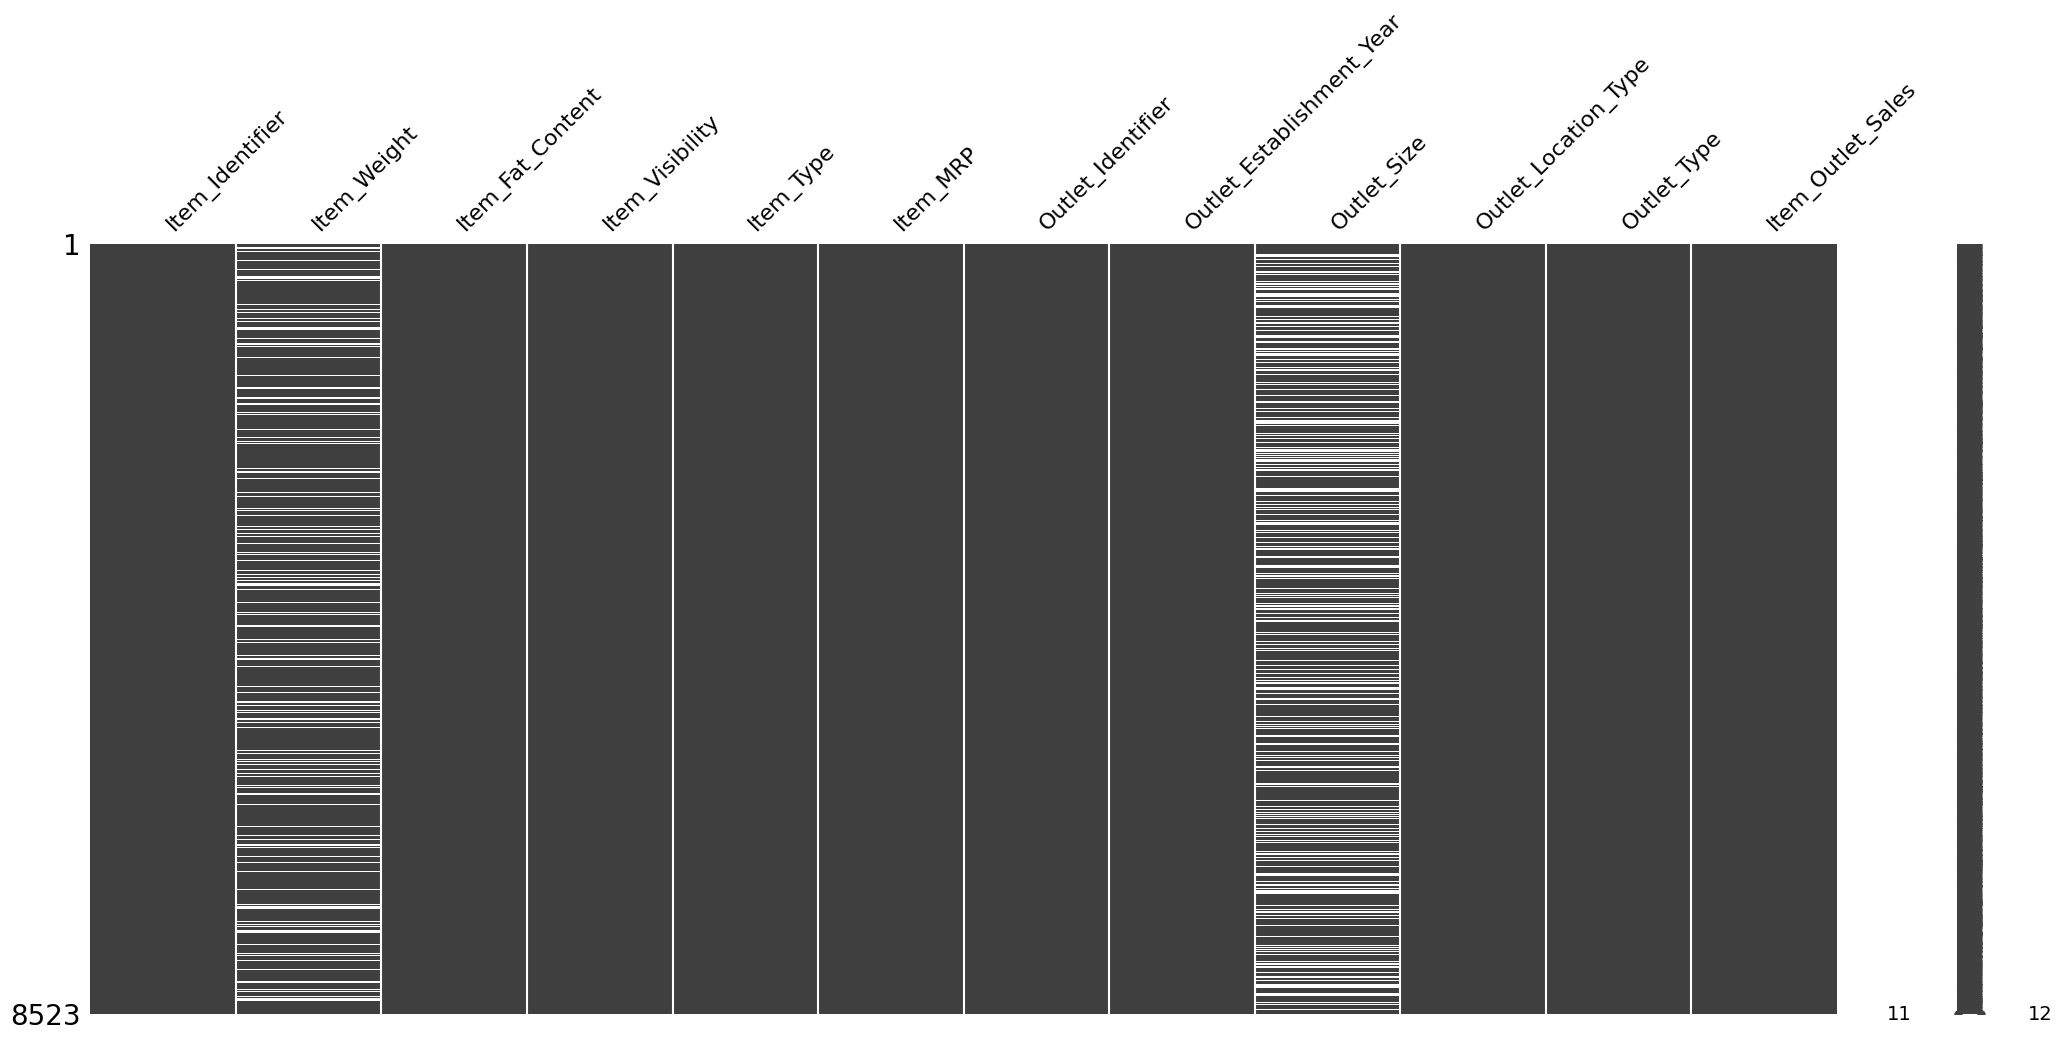

In [22]:
msno.matrix(df);

* (Item weight, outlet size) have a missing values which we will handle in the ML part

###**Handling Inconsistencies**

In [23]:
objects = df.select_dtypes('object').columns
objects

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [24]:
for col in objects:
    print (f'value_count{col}')
    print (df[col].value_counts())
    print('\n')

value_countItem_Identifier
Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64


value_countItem_Fat_Content
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64


value_countItem_Type
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64


value_countOutlet_Identifier
Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OU

* identified (Item_Fat_Content) as a feature that have a inconsistent data values

In [25]:
df ['Item_Fat_Content'] = df['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'})

In [26]:
df['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5517
Regular,3006


In [27]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


* This is summary statistics of each numerical feature (columns) in the dataframe

# Step 4 : **Data Visualization**
#### This is the step where we visualize our data by charts to find any relationship between features.

In [28]:
numbercols = df.select_dtypes('number').columns

In [29]:
num = numbercols.value_counts(normalize=True)
num

,proportion
Item_Weight,0.2
Item_Visibility,0.2
Item_MRP,0.2
Outlet_Establishment_Year,0.2
Item_Outlet_Sales,0.2


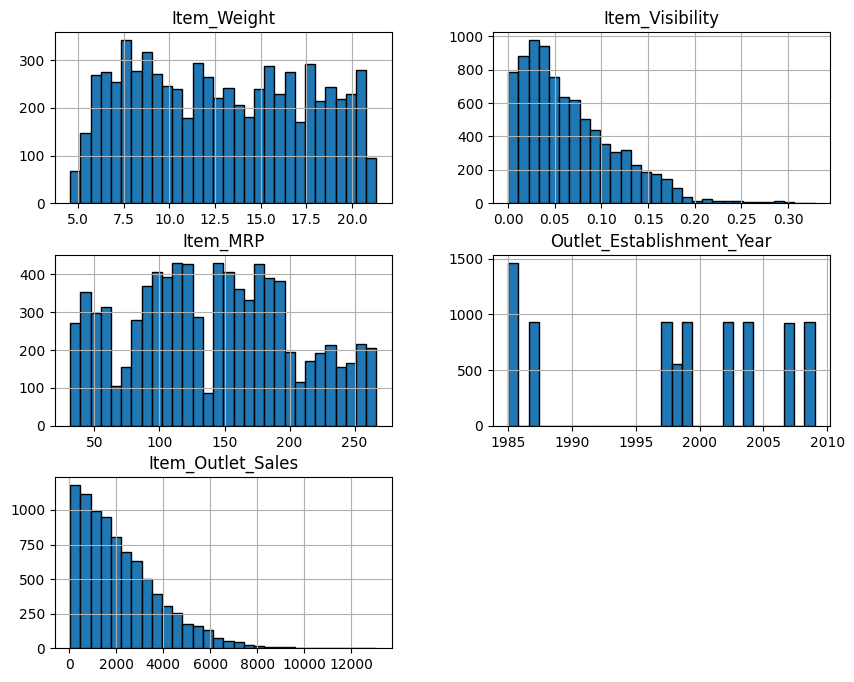

In [30]:
ax = df[numbercols].hist(bins=30,edgecolor='black', figsize=(10,8))

* This is the general distribution of data in the numerical columns of this dataframe.

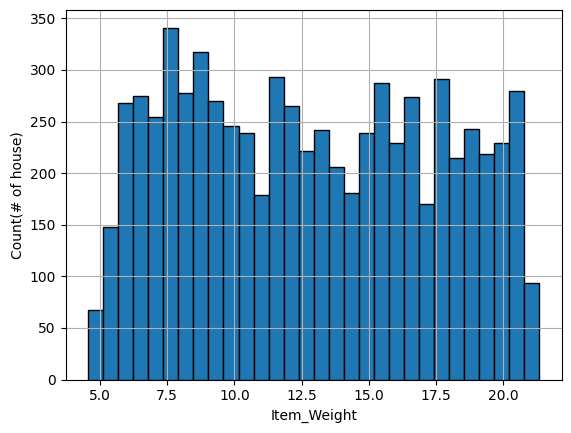

In [31]:
ax = df['Item_Weight'].hist(bins=30,edgecolor='black')
ax.set_ylabel('Count(# of house)');
ax.set_xlabel('Item_Weight');

* plotting 'item weight' feature that have a missing values.

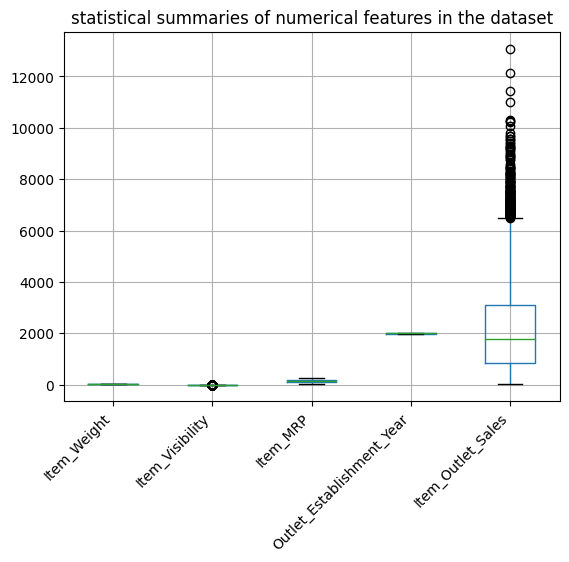

In [32]:
ax = df.boxplot()
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');
ax.set_title('statistical summaries of numerical features in the dataset');

* a statistical summaries of numerical features in the dataset as a boxplot

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


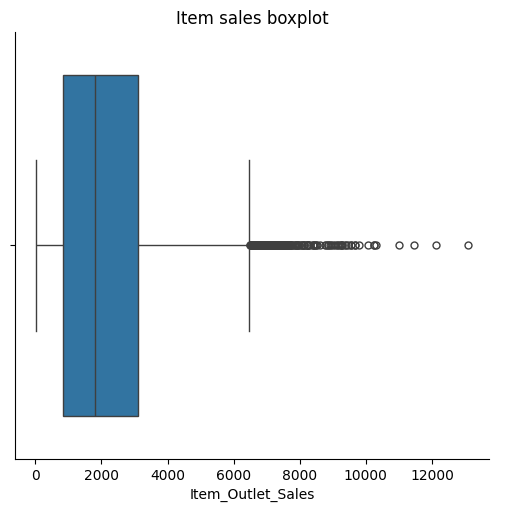

In [33]:
boxplot = sns.catplot(data=df, x='Item_Outlet_Sales',kind='box', dodge=False)
boxplot.ax.set_title('Item sales boxplot');

 * a closer inspection of 'item sales' distribution

In [34]:
black = dict(color='black')
scatters = dict(edgecolor='white')

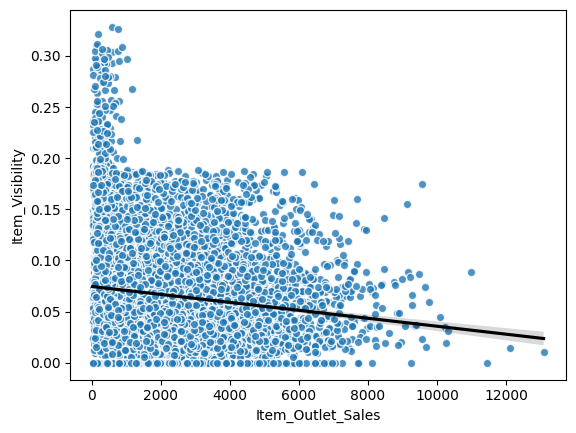

In [35]:
sns.regplot(data=df,x='Item_Outlet_Sales',y='Item_Visibility',line_kws=black, scatter_kws=scatters);

*  this regplot explains the correlation between item visibility and item oulet sales trend.

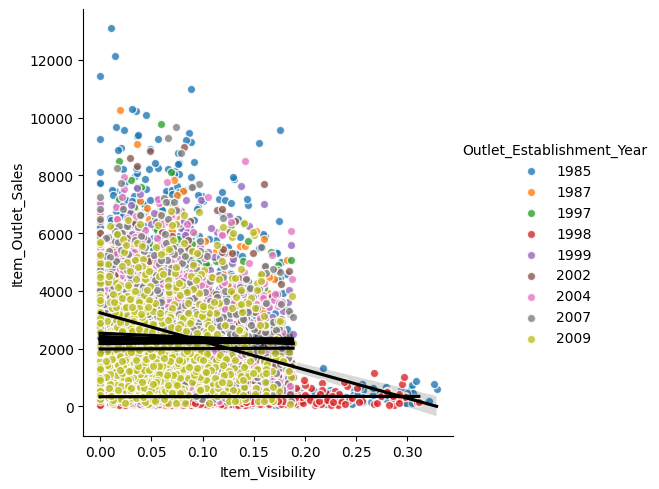

In [36]:
ax = sns.lmplot(data=df,y='Item_Outlet_Sales',x='Item_Visibility',line_kws=black, scatter_kws=scatters, hue='Outlet_Establishment_Year');

* a scatter plot explaining the different relationship between the item visibility and establishment year and the influance on sales

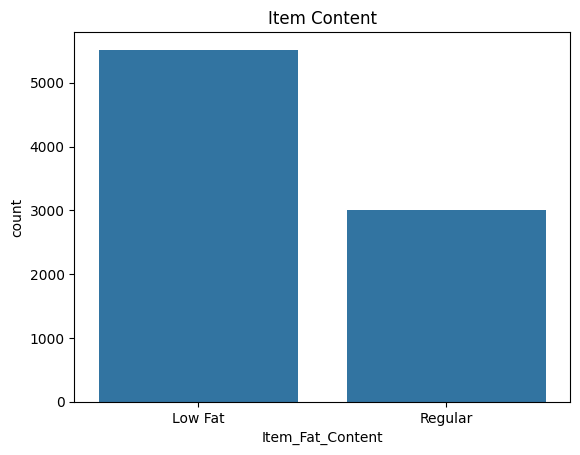

In [37]:
ax = sns.countplot(data=df,x='Item_Fat_Content')
ax.set_title('Item Content');

* item content values count

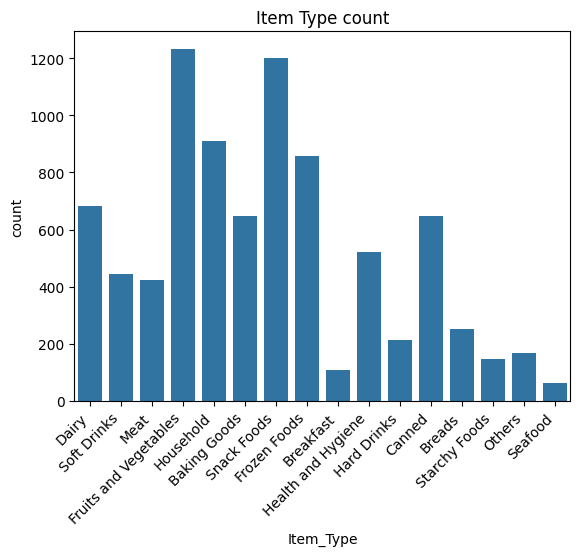

In [38]:
ax = sns.countplot(data=df,x='Item_Type');
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');
ax.set_title('Item Type count');

*  item value counts in the 'item type' feature

In [39]:
val_counts = df['Outlet_Size'].value_counts()
val_counts.index

Index(['Medium', 'Small', 'High'], dtype='object', name='Outlet_Size')

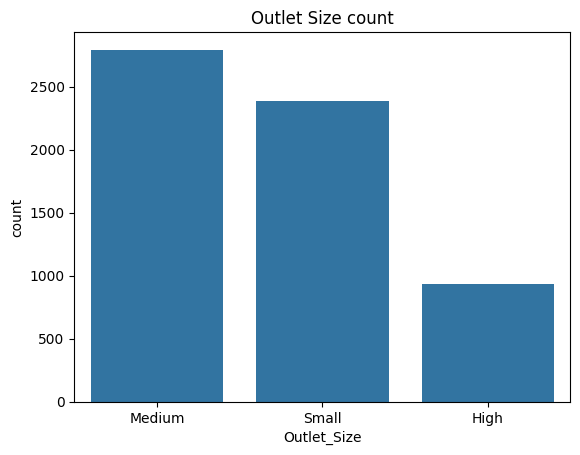

In [40]:
ax = sns.countplot(data=df,x='Outlet_Size',order=val_counts.index);
ax.set_title('Outlet Size count');

*  the value count of "Outlet_Size" by order of the index feature

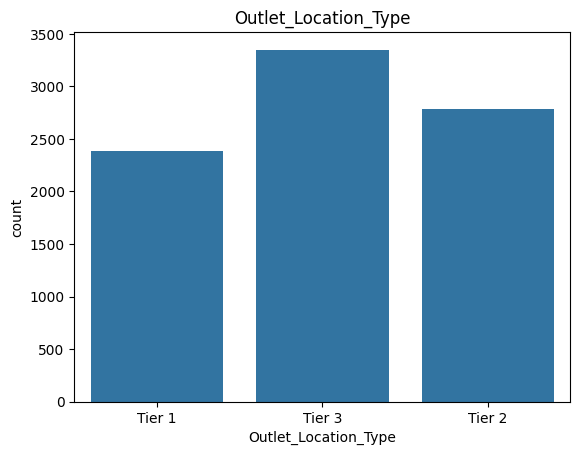

In [41]:
ax = sns.countplot(data=df,x='Outlet_Location_Type')
ax.set_title('Outlet_Location_Type');

* a plot of outlet locations.

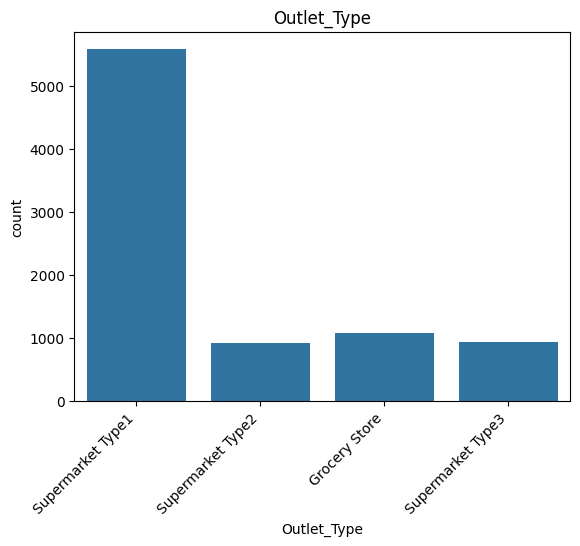

In [42]:
ax = sns.countplot(data=df,x='Outlet_Type')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right');
ax.set_title('Outlet_Type');

In [43]:
cor = df.corr(numeric_only=True)
cor.round(2)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
Item_Weight,1.00,-0.01,0.03,-0.01,0.01
Item_Visibility,-0.01,1.00,-0.00,-0.07,-0.13
Item_MRP,0.03,-0.00,1.00,0.01,0.57
Outlet_Establishment_Year,-0.01,-0.07,0.01,1.00,-0.05
Item_Outlet_Sales,0.01,-0.13,0.57,-0.05,1.00


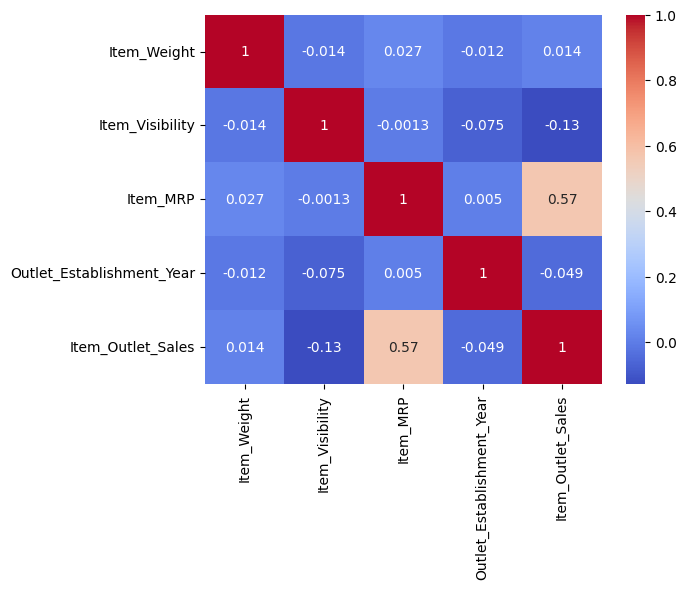

In [44]:
sns.heatmap(cor,cmap='coolwarm',annot=True);

##### a heat map to show the different relations between numerical features positively or negatively as shown.

# Step 5: **Feature Inspection**
#### This is the step where we analyze the dataset features for distribution, correlation, and importance.

### **Inspecting: Item_Weight**

Data Dictionary


* 	Weight of product


#### 1) Univariate Viz

In [45]:
feature_1 = "Item_Weight"

In [46]:
df[feature_1].dtype

dtype('float64')

* Confirming the dtype to select correct EDA function



/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


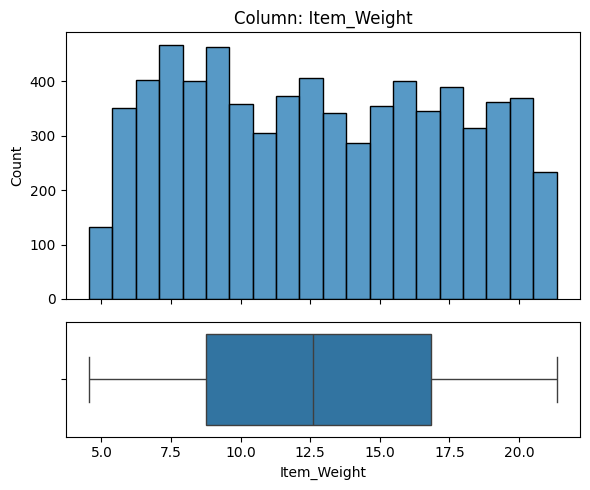

- NaN's Found: 1463 (17.17%)


In [47]:
explore_numeric(df,feature_1)

* its a numerical feature.
* there are 1463 null values which is 17.17% of the feature.
* we should inspect the column for missing values if they are randomly missing or not In order to know how to handle them.
* this feature is not constant or quasi-constant.
* cardinality Not applicable (numeric feature).
* we would know this feature before the target is determined.
* The feature may be beyond the owner's control and it wouldn't be helpful in predicting sale price.

#### 2) Multivariate Viz

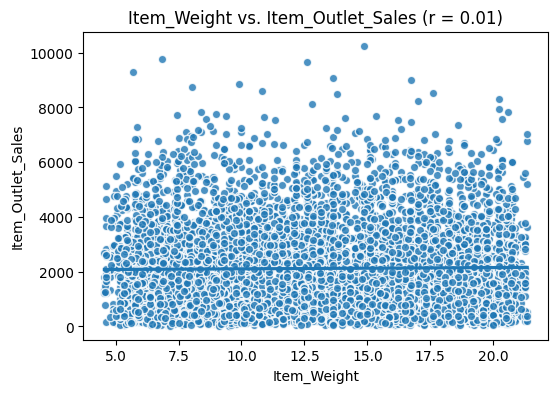

In [48]:
plot_numeric_vs_target(df,feature_1);

* I wouldn't expect the item weight to impact the sale price.
* this feature dosn't appear to be a predictor of the target since its not releated to the sale price trendline.

### **Inspecting: Item_Fat_Content**

Data Dictionary

* regular
* low-fat

#### 1) Univariate Viz

In [49]:
feature_2 = 'Item_Fat_Content'

In [50]:
df[feature_2].dtype

dtype('O')

* Confirming the dtype to select correct EDA function

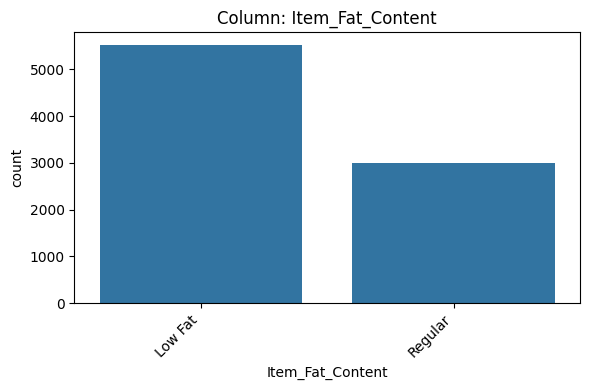

- NaN's Found: 0 (0.0%)
- Unique Values: 2
- Most common value: 'Low Fat' occurs 5517 times (64.73%)
- Not constant or quasi-constant.


In [51]:
explore_categorical(df,feature_2);

* its a categorical feature.
* there are non-null values.
* its not constant or quasi-constant.
* cardinality is low.
* we would know this feature before the target is determined.
* there no need to exclude this feature beacuse it might be releated (negative or positive) to the sale price.

####2) Multivariate Viz

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


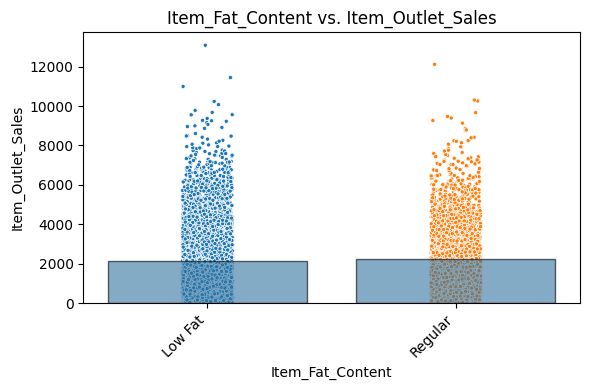

In [52]:
plot_categorical_vs_target(df,feature_2);

* I wouldn't expect the item fat content to impact the sale price due to the close value of regular and low fat items consumption.

* the range of values for item fat content is similar in range of the other categorie so it dosent appear to be a predictor of sale price.

### **Inspecting: Item_Visibility**

Data Dictionary

* Percentage of total display area of all products in a store allocated to the particular product


#### 1) Univariate Viz

In [53]:
feature_3 = "Item_Visibility"

In [54]:
df[feature_3].dtype

dtype('float64')

* Confirming the dtype to select correct EDA function

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


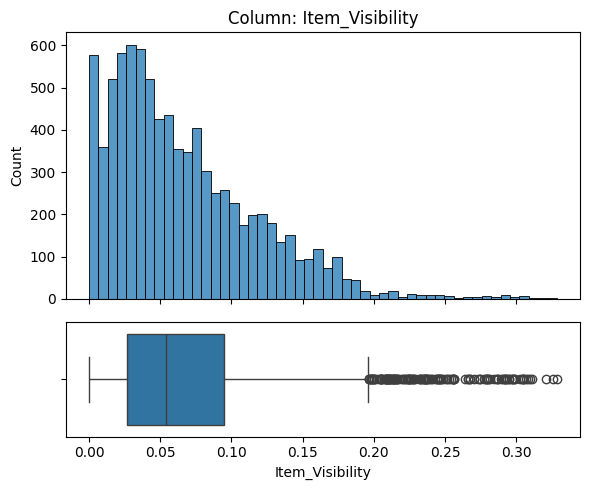

- NaN's Found: 0 (0.0%)


In [55]:
explore_numeric(df,feature_3);

* its a numerical feature.
* there are no null values in this feature.
* this feature is not constant or quasi-constant.
* cardinality Not applicable (numeric feature).
* we would know this feature before the target is determined.
* This feature is not beyond the owner's control and it would be helpful to adjust the future outcomes for our sale price products.

#### 2) Multivariate Viz

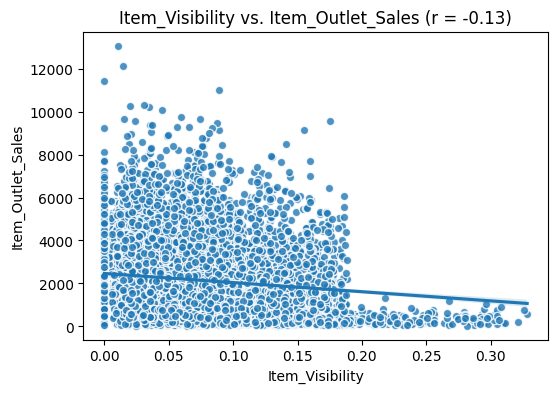

In [56]:
plot_numeric_vs_target(df,feature_3);

* I would expect the item visibility to impact the sale price negativly since its on a negtive slop regration.
* this feature might appear to be a predictor of the target since its releated to the sale price trendline.

### **Inspecting: Item_Type**




Data Dictionary

The category to which the product belongs

#### 1) Univariate Viz

In [57]:
feature_4 = 'Item_Type'

In [58]:
df[feature_4].dtype

dtype('O')

* Confirming the dtype to select correct EDA function


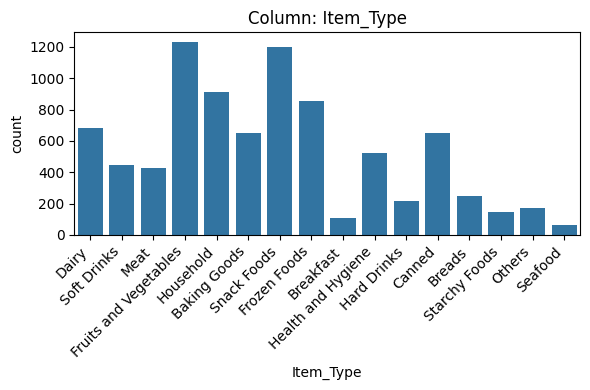

- NaN's Found: 0 (0.0%)
- Unique Values: 16
- Most common value: 'Fruits and Vegetables' occurs 1232 times (14.46%)
- Not constant or quasi-constant.


In [59]:
explore_categorical(df,feature_4);

* its a categorical feature.
* there are non-null values.
* its not constant or quasi-constant.
* cardinality is High.
* we would know this feature before the target is determined.
* there no need to exclude this feature beacuse it is essential to the sale price.

#### 2) Multivariate Viz

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


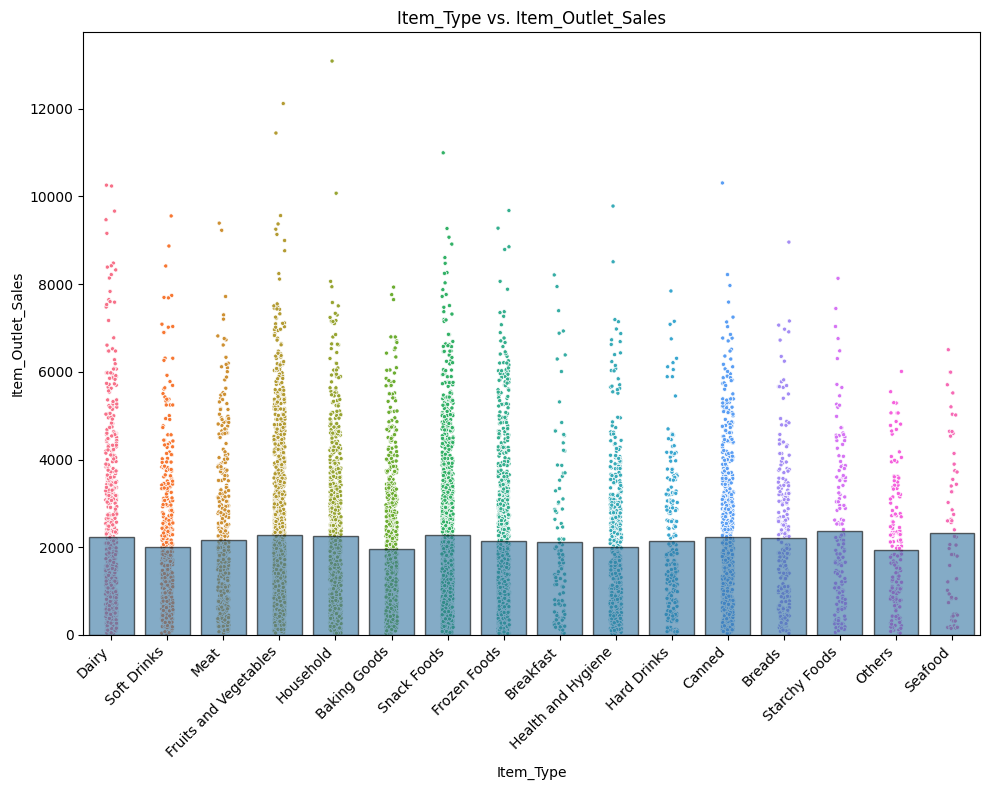

In [60]:
plot_categorical_vs_target(df,feature_4,figsize=(10,8));

* I would expect the Item type content to impact the sale price due to the high values consumption of different content items such as snack foods, fruits and vegetabels.

* the range of values for item type content appears to be a direct predictor of sale prices.

### **Inspecting: Item_MRP**

Data Dictionary

* Maximum Retail Price (list price) of the product

#### 1) Univariate Viz

In [61]:
feature_5 = "Item_MRP"

In [62]:
df[feature_5].dtype

dtype('float64')

* Confirming the dtype to select correct EDA function

/usr/local/lib/python3.10/dist-packages/seaborn/categorical.py:640: FutureWarning: SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
  positions = grouped.grouper.result_index.to_numpy(dtype=float)


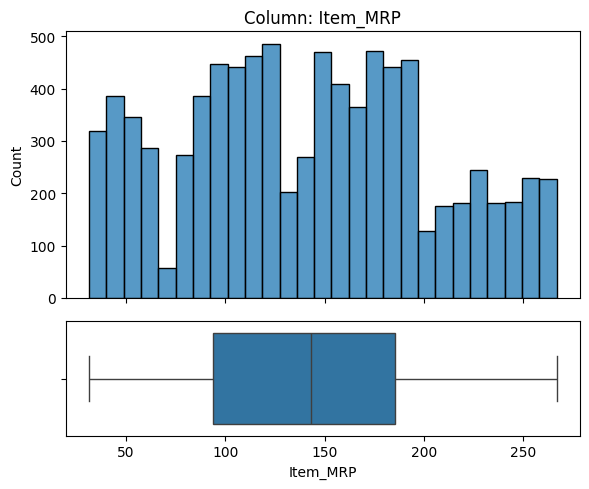

- NaN's Found: 0 (0.0%)


In [63]:
explore_numeric(df,feature_5);

* its a numerical feature.
* there are no null values in this feature.
* this feature is not constant or quasi-constant.
* cardinality Not applicable (numeric feature).
* we would know this feature before the target is determined.
* The feature is in the owner's control and it wouldnt be very helpful in predicting sale prices.

#### 2) Multivariate Viz

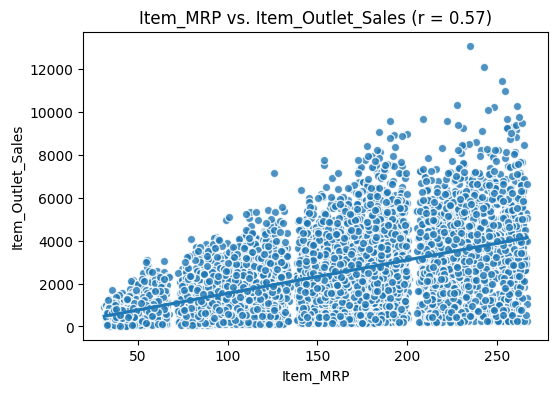

In [64]:
plot_numeric_vs_target(df,feature_5);

* I would expect the item max retail price to impact the sale price since its one of the sale price factors.
* this feature appear to be a predictor of the target since its part of the sale price with a possitive trendline.

# Step 5 : **ML Preprocessing**
#### This is the step where we prepare and transform our dataset for machine learning algorithms.


## Load Data

In [65]:
af = pd.read_csv('/content/drive/MyDrive/StudentFolders16wk24wk/CodingDojo/02-IntroML/Week05/Data/sales_predictions_2023.csv')

## Inspect Data

In [66]:
af.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [67]:
af.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


## Clean Data

In [68]:
af.duplicated().sum()

0

In [69]:
objecto = af.select_dtypes('object').columns
objecto

Index(['Item_Identifier', 'Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Size', 'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')

In [70]:
for col in objecto:
    print (f'value_count{col}')
    print (df[col].value_counts())
    print('\n')

value_countItem_Identifier
Item_Identifier
FDW13    10
FDG33    10
NCY18     9
FDD38     9
DRE49     9
         ..
FDY43     1
FDQ60     1
FDO33     1
DRF48     1
FDC23     1
Name: count, Length: 1559, dtype: int64


value_countItem_Fat_Content
Item_Fat_Content
Low Fat    5517
Regular    3006
Name: count, dtype: int64


value_countItem_Type
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64


value_countOutlet_Identifier
Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018  

In [71]:
af ['Item_Fat_Content'] = af['Item_Fat_Content'].replace({'LF':'Low Fat','low fat':'Low Fat','reg':'Regular'})

In [72]:
af['Item_Fat_Content'].value_counts()

,count
Item_Fat_Content,
Low Fat,5517
Regular,3006


In [73]:
af = af.drop(columns=['Item_Identifier'])

## ML Column Transfer

#### inspect data

In [74]:
af.value_counts()

Item_Weight  Item_Fat_Content  Item_Visibility  Item_Type              Item_MRP  Outlet_Identifier  Outlet_Establishment_Year  Outlet_Size  Outlet_Location_Type  Outlet_Type        Item_Outlet_Sales
4.555        Regular           0.034329         Frozen Foods           110.1544  OUT013             1987                       High         Tier 3                Supermarket Type1  1230.3984            1
15.700       Regular           0.027730         Canned                 169.3790  OUT018             2009                       Medium       Tier 3                Supermarket Type2  1528.0110            1
             Low Fat           0.045166         Frozen Foods           178.6660  OUT013             1987                       High         Tier 3                Supermarket Type1  2516.7240            1
                               0.037384         Soft Drinks            179.7634  OUT018             2009                       Medium       Tier 3                Supermarket Type2  1817.6340            1
                               0.037290         Soft Drinks            182.7634  OUT049             1999                       Medium       Tier 1                Supermarket Type1  3453.5046            1
                                                                                                                                                                                                         ..
9.895        Regular           0.028765         Canned                 115.3492  OUT049             1999                       Medium       Tier 1                Supermarket Type1  1274.3412            1
                               0.028697         Canned                 117.0492  OUT013             1987                       High         Tier 3                Supermarket Type1  810.9444             1
             Low Fat           0.167831         Soft Drinks            237.4564  OUT046             1997                       Small        Tier 1                Supermarket Type1  715.0692             1
                               0.167799         Soft Drinks            239.4564  OUT035             2004                       Small        Tier 2                Supermarket Type1  5243.8408            1
21.350       Low Fat           0.078061         Fruits and Vegetables  96.0094   OUT018             2009                       Medium       Tier 3                Supermarket Type2  380.8376             1
Name: count, Length: 4650, dtype: int64

In [75]:
af.isna().sum()

,0
Item_Weight,1463
Item_Fat_Content,0
Item_Visibility,0
Item_Type,0
Item_MRP,0
Outlet_Identifier,0
Outlet_Establishment_Year,0
Outlet_Size,2410
Outlet_Location_Type,0
Outlet_Type,0


In [76]:
af.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7060.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.643456,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.773750,0.026989,93.826500,1987.000000,834.247400
50%,12.600000,0.053931,143.012800,1999.000000,1794.331000
75%,16.850000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


#### Split Data

In [77]:
X = af.drop(columns = 'Item_Outlet_Sales')
y = af['Item_Outlet_Sales']

In [78]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

#### numeric columns

In [79]:
num_cols = X_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols)

Numeric Columns: Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')


In [80]:
impute_median = SimpleImputer(strategy='median')

In [81]:
scaler = StandardScaler()

In [82]:
num_pipe = make_pipeline(impute_median, scaler)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

In [83]:
num_tuple = ('numeric', num_pipe, num_cols)
num_tuple

('numeric',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                 ('standardscaler', StandardScaler())]),
 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
        'Outlet_Establishment_Year'],
       dtype='object'))

#### ordinal columns

In [84]:
af['Outlet_Size'].value_counts()

,count
Outlet_Size,
Medium,2793
Small,2388
High,932


In [85]:
ord_cols = ['Outlet_Size']
print("Ordinal Columns:", ord_cols)

Ordinal Columns: ['Outlet_Size']


In [86]:
qual_cond_order = ['Small','Medium', 'High']

In [87]:
ordinal_category_orders = [qual_cond_order]

In [88]:
impute_na_ord = SimpleImputer(strategy='most_frequent', fill_value='NA')

In [89]:
ord_encoder = OrdinalEncoder(categories=ordinal_category_orders)

In [90]:
scaler_ord = StandardScaler()

In [91]:
ord_pipe = make_pipeline(impute_na_ord, ord_encoder, scaler_ord)

In [92]:
ord_tuple = ('ordinal', ord_pipe, ord_cols)
ord_tuple

('ordinal',
 Pipeline(steps=[('simpleimputer',
                  SimpleImputer(fill_value='NA', strategy='most_frequent')),
                 ('ordinalencoder',
                  OrdinalEncoder(categories=[['Small', 'Medium', 'High']])),
                 ('standardscaler', StandardScaler())]),
 ['Outlet_Size'])

#### categorical columns

In [93]:
ohe_cols = X_train.select_dtypes('object').drop(columns=ord_cols).columns
print("OneHotEncoder Columns:", ohe_cols)

OneHotEncoder Columns: Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object')


In [94]:
ohe_encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

In [95]:
ohe_pipe = make_pipeline(ohe_encoder)
ohe_pipe

Pipeline(steps=[('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse_output=False))])

In [96]:
ohe_tuple = ('categorical', ohe_pipe, ohe_cols)
ohe_tuple

('categorical',
 Pipeline(steps=[('onehotencoder',
                  OneHotEncoder(handle_unknown='ignore', sparse_output=False))]),
 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
        'Outlet_Location_Type', 'Outlet_Type'],
       dtype='object'))

#### columns transfer

In [97]:
col_transformer = ColumnTransformer([num_tuple, ord_tuple, ohe_tuple],verbose_feature_names_out=False)

In [98]:
col_transformer.fit(X_train)

ColumnTransformer(transformers=[('numeric',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                ('ordinal',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='NA',
                                                                strategy='most_frequent')),
                                                 ('ord...
                                                  OrdinalEncoder(categories=[['Small',
                                                                              'Medium',
                                                                              'High']])),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 ['Outlet_Size']),
                                ('categorical',
                                 Pipeline(steps=[('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False))]),
                                 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                  verbose_feature_names_out=False)

In [99]:
X_train_processed = col_transformer.transform(X_train)

In [100]:
X_test_processed = col_transformer.transform(X_test)

#### columns transfer inspection

In [101]:
X_train_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
4776,0.827485,-0.712775,1.828109,1.327849,0.287374,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
7510,0.566644,-1.291052,0.603369,1.327849,0.287374,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
5828,-0.121028,1.813319,0.244541,0.136187,0.287374,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
5327,-1.158464,-1.004931,-0.952591,0.732018,-1.384048,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4810,1.538870,-0.965484,-0.336460,0.493686,0.287374,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


In [102]:
X_test_processed.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Type_Baking Goods,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Identifier_OUT010,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,0.341372,-0.776646,-0.998816,-1.293807,1.958796,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2957,-1.169135,0.100317,-1.585194,-0.102145,-1.384048,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
7031,0.388798,-0.482994,-1.595784,0.136187,0.287374,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1084,-0.049889,-0.415440,0.506592,-1.532139,0.287374,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
856,-0.632039,-1.047426,0.886725,0.732018,-1.384048,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


# Step 6 : **Machine Learning Models**
#### This is the step where we train and test our dataset with machine learning algorithms.

## Linear Regression Model

In [103]:
linreg = LinearRegression()

In [104]:
linreg_pipe = make_pipeline(col_transformer, linreg)

In [105]:
linreg_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value=...
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  ['Outlet_Size']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('linearregression', LinearRegression())])

In [106]:
evaluate_regression(linreg_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.145
- MSE = 1,297,561.792
- RMSE = 1,139.106
- R^2 = 0.562

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 804.125
- MSE = 1,194,316.906
- RMSE = 1,092.848
- R^2 = 0.567


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


* as we notice the out come of this Linear regression model with the training data and the test data is **Underfitting** since the R^2 values on both is 56.7%

## Linear Regression Model Coefficients

### Pipline Coefficients

In [107]:
feature_names = linreg_pipe[0].get_feature_names_out()
feature_names

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Size',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Type_Baking Goods', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Location_Type_Tier 1', 'Outlet_Location_Type_Tier 2',
       'Outlet_

In [108]:
linreg_pipe[-1].coef_

array([-7.07138012e+00, -2.17635357e+01,  9.84577590e+02,  1.76892916e+15,
        5.64629297e+14, -1.14932371e+13, -1.14932371e+13, -2.42685796e+14,
       -2.42685796e+14, -2.42685796e+14, -2.42685796e+14, -2.42685796e+14,
       -2.42685796e+14, -2.42685796e+14, -2.42685796e+14, -2.42685796e+14,
       -2.42685796e+14, -2.42685796e+14, -2.42685796e+14, -2.42685796e+14,
       -2.42685796e+14, -2.42685796e+14, -2.42685796e+14, -2.69253516e+15,
        1.60607565e+15, -1.21271061e+15, -1.90619705e+15,  2.88115173e+14,
       -6.72571176e+14,  3.63412747e+14, -1.58728055e+14,  6.82140043e+14,
       -6.83186804e+14,  3.25861279e+14, -8.30987004e+14, -3.77576860e+14,
       -1.54305198e+15, -4.46663499e+15, -4.64815171e+15, -8.22661315e+14])

In [109]:
coeffs = pd.Series(linreg_pipe[-1].coef_, index=feature_names)
coeffs

,0
Item_Weight,-7.071380e+00
Item_Visibility,-2.176354e+01
Item_MRP,9.845776e+02
Outlet_Establishment_Year,1.768929e+15
Outlet_Size,5.646293e+14
Item_Fat_Content_Low Fat,-1.149324e+13
Item_Fat_Content_Regular,-1.149324e+13
Item_Type_Baking Goods,-2.426858e+14
Item_Type_Breads,-2.426858e+14
Item_Type_Breakfast,-2.426858e+14


### Coefficients Plot

In [110]:
af['Outlet_Identifier'].value_counts()

,count
Outlet_Identifier,
OUT027,935
OUT013,932
OUT049,930
OUT046,930
OUT035,930
OUT045,929
OUT018,928
OUT017,926
OUT010,555


In [111]:
drop = ['Outlet_Identifier']

In [112]:
X2 = af.drop(columns=[*drop,'Item_Outlet_Sales'])
y2 = af['Item_Outlet_Sales']

In [113]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, random_state = 42)

In [114]:
num_cols2 = X2_train.select_dtypes("number").columns
print("Numeric Columns:", num_cols2)
impute_median2 = SimpleImputer(strategy='median')
scaler = StandardScaler()
num_pipe2 = make_pipeline(impute_median2, scaler)
num_tuple2 = ('numeric', num_pipe2, num_cols2)

Numeric Columns: Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')


In [115]:
ord_cols2 = ['Outlet_Size']
print("Ordinal Columns:", ord_cols)
qual_cond_order2 = ['Small','Medium', 'High']

ordinal_category_orders2 = [qual_cond_order2]
impute_na_ord2 = SimpleImputer(strategy='most_frequent')
ord_encoder2 = OrdinalEncoder(categories=ordinal_category_orders2)
scaler_ord = StandardScaler()
ord_pipe2 = make_pipeline(impute_na_ord2, ord_encoder2, scaler_ord)
ord_tuple2 = ('ordinal', ord_pipe2, ord_cols2)

Ordinal Columns: ['Outlet_Size']


In [117]:
ohe_cols2 = X2_train.select_dtypes('object').drop(columns=ord_cols2).columns
print("OneHotEncoder Columns:", ohe_cols2)
impute_cat2 = SimpleImputer(strategy='most_frequent')
ohe_encoder2 = OneHotEncoder(drop = 'first',sparse_output=False)
ohe_pipe2 = make_pipeline(impute_cat2,ohe_encoder2)
ohe_tuple2 = ('categorical', ohe_pipe2, ohe_cols2)
ohe_tuple2

OneHotEncoder Columns: Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object')


('categorical',
 Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='most_frequent')),
                 ('onehotencoder',
                  OneHotEncoder(drop='first', sparse_output=False))]),
 Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Location_Type', 'Outlet_Type'], dtype='object'))

In [118]:
col_transformer2= ColumnTransformer([num_tuple2, ord_tuple2, ohe_tuple2],verbose_feature_names_out=False)

In [119]:
col_transformer2.fit(X2_train)
feature_names2 = col_transformer2.get_feature_names_out()
X2_train_df = pd.DataFrame(col_transformer2.transform(X2_train), columns = feature_names2, index = X2_train.index)
X2_test_df = pd.DataFrame(col_transformer2.transform(X2_test), columns = feature_names2, index = X2_test.index)
X2_test_df.head(3)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Item_Fat_Content_Regular,Item_Type_Breads,Item_Type_Breakfast,Item_Type_Canned,Item_Type_Dairy,Item_Type_Frozen Foods,Item_Type_Fruits and Vegetables,Item_Type_Hard Drinks,Item_Type_Health and Hygiene,Item_Type_Household,Item_Type_Meat,Item_Type_Others,Item_Type_Seafood,Item_Type_Snack Foods,Item_Type_Soft Drinks,Item_Type_Starchy Foods,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
7503,0.341372,-0.776646,-0.998816,-1.293807,1.958796,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
2957,-1.169135,0.100317,-1.585194,-0.102145,-1.384048,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7031,0.388798,-0.482994,-1.595784,0.136187,0.287374,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [120]:
# fitting a linear regression model
lin_reg2 = LinearRegression()
lin_reg2.fit(X2_train_df, y2_train)
evaluate_regression(lin_reg2, X2_train_df, y2_train, X2_test_df,y2_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 847.417
- MSE = 1,300,449.203
- RMSE = 1,140.372
- R^2 = 0.561

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 805.272
- MSE = 1,197,575.991
- RMSE = 1,094.338
- R^2 = 0.566


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [121]:
lin_reg2.feature_names_in_

array(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Outlet_Size',
       'Item_Fat_Content_Regular', 'Item_Type_Breads',
       'Item_Type_Breakfast', 'Item_Type_Canned', 'Item_Type_Dairy',
       'Item_Type_Frozen Foods', 'Item_Type_Fruits and Vegetables',
       'Item_Type_Hard Drinks', 'Item_Type_Health and Hygiene',
       'Item_Type_Household', 'Item_Type_Meat', 'Item_Type_Others',
       'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Location_Type_Tier 2', 'Outlet_Location_Type_Tier 3',
       'Outlet_Type_Supermarket Type1', 'Outlet_Type_Supermarket Type2',
       'Outlet_Type_Supermarket Type3'], dtype=object)

In [122]:
coeffs2 = pd.Series(lin_reg2.coef_, index= lin_reg2.feature_names_in_)
coeffs2['intercept'] = lin_reg2.intercept_
coeffs2

,0
Item_Weight,-7.496647
Item_Visibility,-21.589480
Item_MRP,984.231549
Outlet_Establishment_Year,6.556945
Outlet_Size,-9.927403
Item_Fat_Content_Regular,63.055608
Item_Type_Breads,-29.882424
Item_Type_Breakfast,47.334326
Item_Type_Canned,25.464592
Item_Type_Dairy,-105.799578


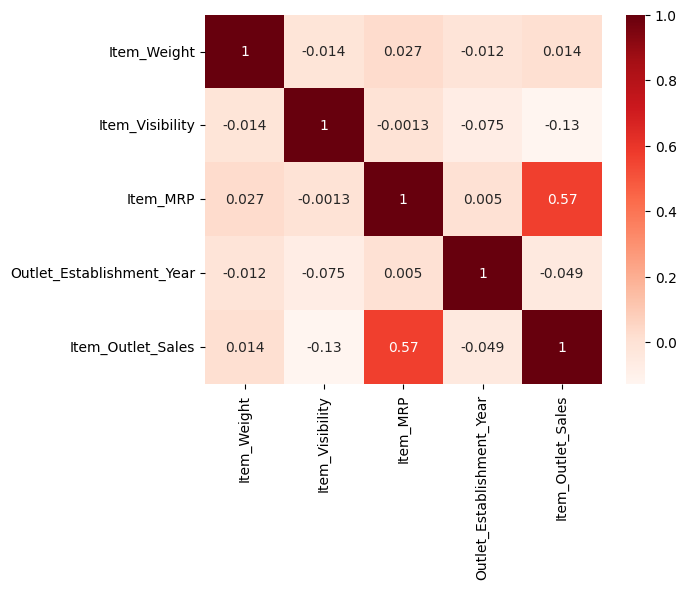

In [123]:
cor = af.corr(numeric_only=True)
cor.round(2)

sns.heatmap(cor,cmap='Reds',annot=True);


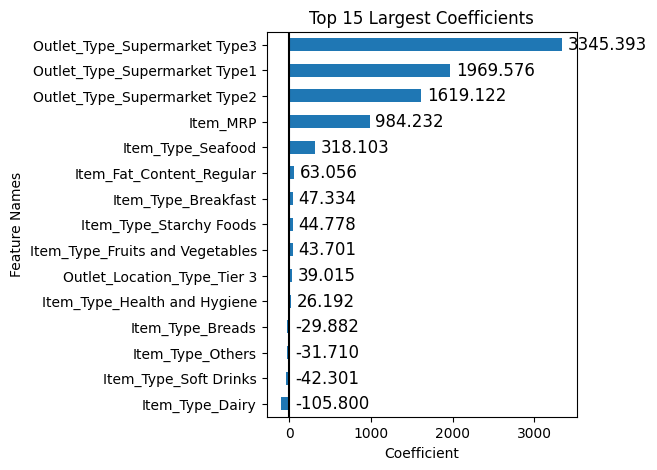

In [124]:
plot_coeffs(coeffs2, top_n=15, annotate=True);

## Random Forest Model

In [125]:
rf = RandomForestRegressor(random_state = 42)

In [126]:
rf_pipe = make_pipeline(col_transformer, rf)

In [127]:
rf_pipe.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('numeric',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                 ('ordinal',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value=...
                                                                   StandardScaler())]),
                                                  ['Outlet_Size']),
                                                 ('categorical',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False))]),
                                                  Index(['Item_Fat_Content', 'Item_Type', 'Outlet_Identifier',
       'Outlet_Location_Type', 'Outlet_Type'],
      dtype='object'))],
                                   verbose_feature_names_out=False)),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=42))])

In [128]:
evaluate_regression(rf_pipe, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 296.124
- MSE = 182,241.944
- RMSE = 426.898
- R^2 = 0.938

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 765.671
- MSE = 1,213,934.180
- RMSE = 1,101.787
- R^2 = 0.560


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


* as we notice the out come of this Random Forest model with the training data and the test data is **Overfitting** since the R^2 values on the training is 93.8% and 56% on the test data.
* in comparison with the linear regression model we may expect a better results in preformance to our goals if we modify this random forest model.

## Random Forest GridSearchCV

In [129]:
rf_pipe.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('numeric',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(strategy='median')),
                                                    ('standardscaler',
                                                     StandardScaler())]),
                                    Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
          'Outlet_Establishment_Year'],
         dtype='object')),
                                   ('ordinal',
                                    Pipeline(steps=[('simpleimputer',
                                                     SimpleImputer(fill_value='NA',
                                                                   strategy='most_frequent')),
                                                    ('ord...
                                                     OrdinalEncoder(categories=[['Small

In [130]:
params = {'randomforestregressor__max_depth': [None,10,15,20],
          'randomforestregressor__n_estimators':[10,100,150,200],
          'randomforestregressor__min_samples_leaf':[2,3,4],
          'randomforestregressor__max_features':['sqrt','log2',None],
          'randomforestregressor__oob_score':[True,False],
          }

In [131]:
gridsearch = GridSearchCV(rf_pipe, params, n_jobs=-1, cv = 3, verbose=1)

In [132]:
gridsearch.fit(X_train, y_train)

Fitting 3 folds for each of 288 candidates, totalling 864 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(transformers=[('numeric',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('standardscaler',
                                                                                          StandardScaler())]),
                                                                         Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year'],
      dtype='object')),
                                                                        ('ordinal',
                                                                         Pipeline(steps=[('simpleimpute...
                                       ('randomforestregressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'randomforestregressor__max_depth': [None, 10, 15, 20],
                         'randomforestregressor__max_features': ['sqrt', 'log2',
                                                                 None],
                         'randomforestregressor__min_samples_leaf': [2, 3, 4],
                         'randomforestregressor__n_estimators': [10, 100, 150,
                                                                 200],
                         'randomforestregressor__oob_score': [True, False]},
             verbose=1)

In [133]:
gridsearch.best_params_

{'randomforestregressor__max_depth': 10,
 'randomforestregressor__max_features': None,
 'randomforestregressor__min_samples_leaf': 3,
 'randomforestregressor__n_estimators': 100,
 'randomforestregressor__oob_score': True}

In [134]:
best_rf = gridsearch.best_estimator_

In [135]:
evaluate_regression(best_rf, X_train, y_train, X_test, y_test)

------------------------------------------------------------
Regression Metrics: Training Data
------------------------------------------------------------
- MAE = 653.622
- MSE = 868,801.486
- RMSE = 932.095
- R^2 = 0.706

------------------------------------------------------------
Regression Metrics: Test Data
------------------------------------------------------------
- MAE = 734.606
- MSE = 1,118,768.607
- RMSE = 1,057.719
- R^2 = 0.594


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


* as expected we have seen an improvment on both traning and testing data preformace in comparison to the defualt model without any hypertuning, for the training data we have r^2 value of 70% and for the testing data we have r^2 value at 59.4%.

## Random Forest Importances Features

In [136]:
feature_names = best_rf[0].get_feature_names_out()
# Get importances
importances = pd.Series(best_rf[-1].feature_importances_, index=feature_names)
importances

importances.sort_values(ascending=False)


,0
Item_MRP,0.516163
Outlet_Type_Grocery Store,0.266817
Outlet_Identifier_OUT027,0.055866
Item_Visibility,0.045853
Outlet_Type_Supermarket Type3,0.034340
Outlet_Establishment_Year,0.023184
Item_Weight,0.019279
Item_Type_Fruits and Vegetables,0.003009
Item_Type_Snack Foods,0.002795
Item_Type_Household,0.002308


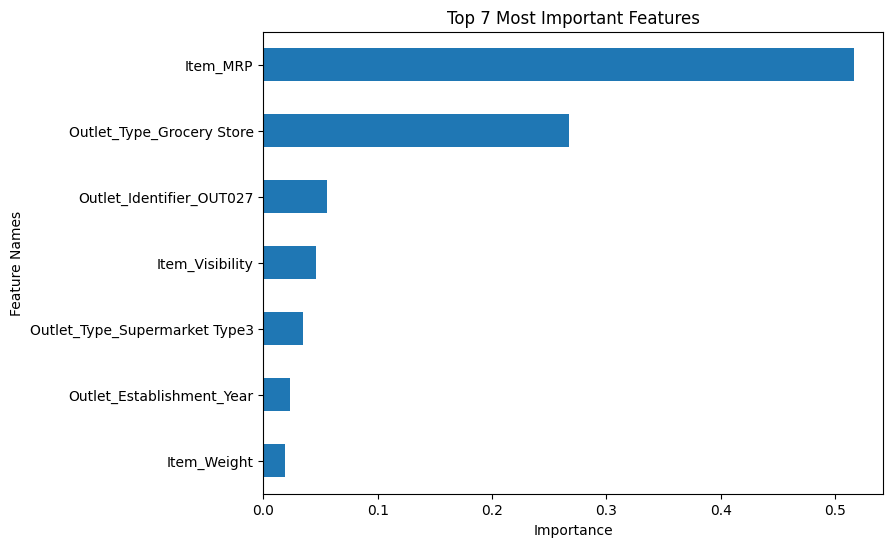

In [137]:
plot_importance(importances, top_n=7);

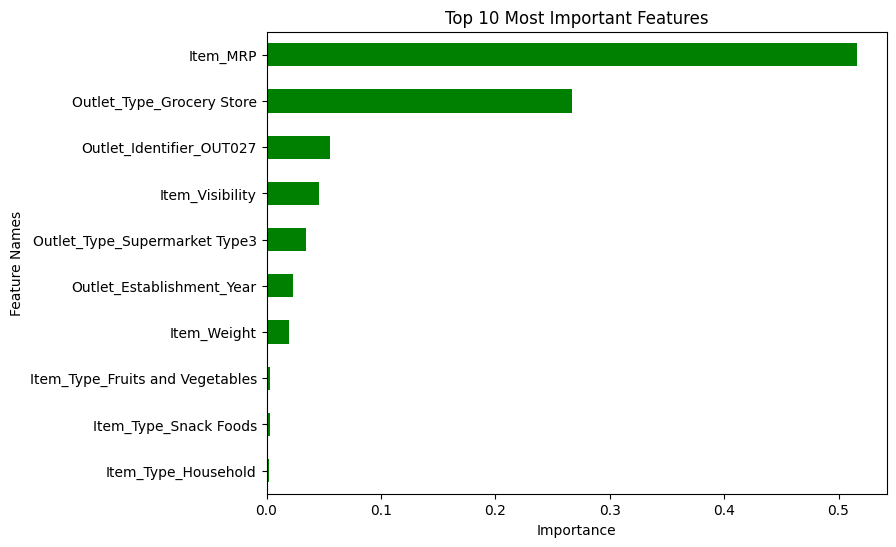

In [138]:
plot_importance_color(importances, top_n=10,  figsize=(8,6),color_dict=get_color_dict(importances, color_rest='#006ba4' , color_top='green',top_n=10));

##  Evaluation

* Linear Regression Model (Testing Set):

 MAE = 804.089

 MSE = 1,194,326.602

 RMSE = 1,092.853

 R^2 = 0.567

* Random Forest Regressor Model (Testing Set):

 MAE = 765.671

 MSE = 1,213,934.180

 RMSE = 1,101.787

 R^2 = 0.560

* Tuned Random Forest Regressor Model (Testing Set):

 MAE = 734.606

 MSE = 1,118,768.607
  
 RMSE = 1,057.719
  
 R^2 = 0.594

---

 The Final Model Chosen was the Random Forest Regressor Model hyperparameters tuned.

 * For the testing set on the model, 59.4% of the variance in y was explained by x, which was the closest model to predict the test data in compartion to the traning data by just a 11.2% bias.

 * The Mean Absolute Error was off by about $734,606.

 * The Mean Squared Error was $1,118,768.607.

 * The Root Mean Squared Error had a calculation of $1,057.719.

* Using this model to make predictions about increasing the sales income would be somehow reliable since the target we are trying to predect had the most score presentage for the test data which is 59.4%.

* Considering the previous regression metrics from how the model performed,  the Root Mean Squared Error is not that high which is around 1000$ which is understandable error, considering the model also leaning into underfiting is not be ignored.
